#### Reasources
* Youtube Course List - https://www.youtube.com/playlist?list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH
* Github Repo - https://github.com/nicknochnack/FaceRecognition
* Siamese Neural Networks for One-shot Image Recognition - https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
* Labeled Faces in the Wild - http://vis-www.cs.umass.edu/lfw/
* TF Functional API - https://www.tensorflow.org/guide/keras/functional_api

* Did't finish the last part (Kivy App) - https://www.youtube.com/watch?v=43eAC1LMrsU&list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH&index=8

## Setup

#### What is One-Shot Classification.
**One-shot classification** is a type of machine learning task where the goal is to classify an object based on a single example of that object. This is in contrast to traditional classification tasks, where the model is trained on a large dataset of examples. **One-shot classification** is a challenging task because it requires the model to generalize from a single example to a new object.

There are a number of different approaches to **one-shot classification**. One common approach is to use a ***Siamese network***. **A Siamese network** is a type of neural network that is trained to compare two images. In the context of **one-shot classification**, **the Siamese network** is trained to compare an image of the object to be classified to a single example of the object. If the two images are of the same object, the ***Siamese*** network will output a high score. If the two images are of different objects, the ***Siamese*** network will output a low score.

Another approach to ***one-shot classification*** is to use a **meta-learning** algorithm. **Meta-learning** algorithms are designed to learn from a small number of examples. In the context of **one-shot classification**, the ***meta-learning algorithm*** is trained on a dataset of few-shot classification tasks. Once the **meta-learning** algorithm is trained, it can be used to classify new objects based on a single example.

In [ ]:
# %pip install opencv-python
%pip install tensorflow

In [1]:
# Import Standard dependencies

import cv2 as cv
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#  Import tensorflow dependencies - Functional API
import tensorflow as tf

#### Set GPU Growth
Avoid Out Of Memory(OOM) errors by setting GPU Memory Consumption Growth

In [3]:
# Setting GPU Growth 
gpus = tf.config.experimental.list_physical_devices('GPU') # Select all GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu , True) # Set memory growth to True
print("GPUs :",gpus)

GPUs : []


#### Create Folder Structure

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## Collect Positive and Anchors

#### Untar Labelled Faces in the Wild Dataset

In [ ]:
import requests

if not os.path.isfile('lfw.tgz'):
    URL = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
    response = requests.get(URL)
    open('lfw.tgz', 'wb').write(response.content)

    # Uncompress Tar GZ Labelled Faces in the Wild Dataset
    !tar -xf lfw.tgz -C data

In [ ]:
for directory in os.listdir('data/lfw'):
    for file in os.listdir(os.path.join('data/lfw', directory)):
        EX_PATH = os.path.join('data/lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH , file)
        os.replace(EX_PATH,NEW_PATH)

# Remove the old path data file
! rm -r data/lfw

'rm' is not recognized as an internal or external command,
operable program or batch file.


#### Collect Positive and Anchor Classes

In [5]:
# Import uuid Library to generate unique image names
import uuid

In [8]:
# Establish a connection to the webcam
cap = cv.VideoCapture(0)
while cap.isOpened():
    ret , frame = cap.read()
    
    # Cut down frame to 250x250px
    frame = frame[120:120+250 , 200:200+250 , :]
    
    # Collect anchors
    if cv.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH , '{}.png'.format(uuid.uuid1()))
        # Write out anchor image
        cv.imwrite(imgname , frame)
    
    # Collect positives
    if cv.waitKey(1) & 0XFF == ord('p'):
         # Create the unique file path
        imgname = os.path.join(POS_PATH , '{}.png'.format(uuid.uuid1()))
        # Write out anchor image
        cv.imwrite(imgname , frame)
    
    # Show image back to the screen
    cv.imshow("Image Collections" , frame)
    
    # Breaking gracefully
    if cv.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv.destroyAllWindows()

## Load and Preprocess Images

#### Get Images Directories (Creating Datasets)

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"\\*.png").take(300)
positive = tf.data.Dataset.list_files(POS_PATH+"\\*.png").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+"\\*.jpg").take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\bde25ed9-37df-11ee-89fb-38f3ab757ef3.png'

#### Preprocessing - Scale & Resize

In [8]:
def preprocess(file_path):
    """Preprocess the data and save it to a file."""
    
    # Read in image from file path
    byte_image = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_image)
    
    # Preprocessing steps - Resizing the image to be 100x100x3
    img = tf.image.resize(img , (100,100))
    # Scaling image between 0 and 1
    img = img / 255.0
    
    return img

#### Create Labelled Dataset

In [9]:
# (abchor , positive) => 1,1,1,1,1
# (abchor , negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor , positive , tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor , negative , tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

positives.as_numpy_iterator().next(), negatives.as_numpy_iterator().next()

((b'data\\anchor\\bc8607bd-37df-11ee-9496-38f3ab757ef3.png',
  b'data\\positive\\ddd39cfd-37df-11ee-9865-38f3ab757ef3.png',
  1.0),
 (b'data\\anchor\\c12f7809-37df-11ee-bd93-38f3ab757ef3.png',
  b'data\\negative\\Roger_Clemens_0001.jpg',
  0.0))

#### Build Train and Test Partitions

In [10]:
def preprocess_twin(input_img , validation_img , label):
    return (preprocess(input_img) , preprocess(validation_img) , label)

In [ ]:
T , t , l = preprocess_twin(*data.as_numpy_iterator().next())
plt.imshow(T)
plt.axis('off')
plt.title(l);

In [12]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [13]:
len(data.as_numpy_iterator().next())

3

In [14]:
type(data)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [15]:
# Training Partition
train_data = data.take(round(len(data)* .7)) # 70% of the data
train_data = train_data.batch(16) # 16 image per batch
train_data = train_data.prefetch(8)

In [16]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [17]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [18]:
len(data.as_numpy_iterator().next()),  len(train_data.as_numpy_iterator().next()[0])

(3, 16)

In [19]:
# Testing Partitions
test_data = data.skip(round(len(data)* .7)) # skip first 70% of the data
test_data = test_data.take(round(len(data) * .3))  # take 30% of the data
test_data = test_data.batch(16) # batching the data - 16 image per batch
test_data = test_data.prefetch(8)

In [20]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Model Engineering

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

#### Building Embedding Layer
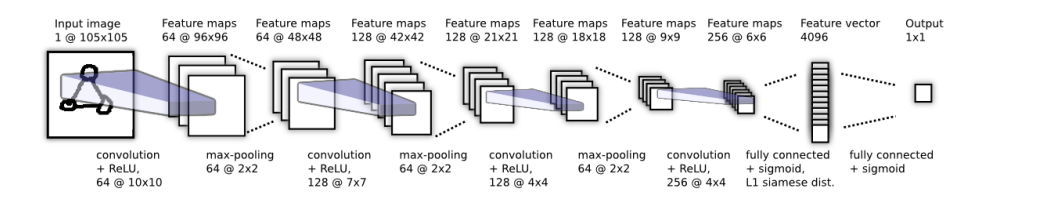

In [22]:
def make_embedding():
    # Create input layer
    inp = Input(shape = (100,100,3) , name = 'Input_Image') 
    
    ### 1st Block
    # Create 1st conv layer
    c1 = Conv2D(64 , (10,10) , activation = 'relu')(inp)
    # Creating maxpooling layer
    m1 = MaxPooling2D(64, (2,2) , padding = 'same')(c1)
    
    ### 2nd Block
    c2 = Conv2D(128 , (7,7) , activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2) , padding = 'same')(c2)
    
    ### 3rd Block
    c3 = Conv2D(128 , (4,4) , activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2) , padding = 'same')(c3)
    
    # Final block
    c4 = Conv2D(256 , (4,4) , activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096 , activation = 'sigmoid')(f1)
    
    return Model(inputs = [inp] , outputs = [d1] , name = 'Embedding')

In [23]:
embedding = make_embedding()
embedding.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

#### Build Distance Layer

In [24]:
# Siamese L1 Distance class

class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self , **kwargs):
        super().__init__()
    
    # Magic happens here.
    def call(self , input_embedding , validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

#### Create Siamese Model

In [25]:
def make_siamese_model():
    
    # Anchor iamge input in the network
    input_image = Input(name = 'name_img' , shape = (100,100,3))
    
    # validation iamge in the network
    validation_image = Input(name = 'validation_img' , shape = (100,100,3))
    
    # Combine siamese distance conponents
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image) , embedding(validation_image))
    
    # Classification layer
    classifier = Dense( 1 , activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image , validation_image] , outputs = classifier , name = 'SiameseNetwork')

In [26]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 name_img (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Embedding (Functional)      (None, 4096)                 3896044   ['name_img[0][0]',            
                                                          8          'validation_img[0][0]']      
                                                                                     

## Training

#### Setup Loss and Optimizer
>**NOTE** you can set `from_logits = True`, this is recommended when the inputs to the loss function are not normalized.

In [27]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [28]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### Establish Chechpoints
>**NOTE** To reload from the checkpoint you can use `model.load('path to checkpoint)`, This will load the pre trained weights into the existing model.

In [29]:
!mkdir training_checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir , 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

A subdirectory or file training_checkpoints already exists.


#### Build Training Step
The basic flow for training on one batch is as follows:
1. Make a prediction
2. Calculate loss
3. Derive Gradients
4. Calculate new weights and apply

In [30]:
batch_1 = train_data.as_numpy_iterator().next()
np.array(batch_1[:2]).shape

(2, 16, 100, 100, 3)

In [31]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X , training = True)
        
        # Calcualte Loss
        loss = binary_cross_loss(y , yhat)
        
    # Calcualte gradients
    grad = tape.gradient(loss , siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad , siamese_model.trainable_variables))
    
    return loss

#### Build Training loop

In [32]:
def train(data , EPOCHS):
    # Loop through epochs
    for epoch in range( 1 , EPOCHS+1):
        print("Epoch {}/{}".format(epoch , EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        # Loop through each batch
        for idx , batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save Checkpoints
        if epoch % 10 == 0 :
            checkpoint.save(file_prefix=checkpoint_prefix)

#### Train the Model

In [54]:
EPOCHS = 30

In [55]:
train(train_data , EPOCHS)

Epoch 1/30
2/2 [==============================] - 20s 7s/step
Epoch 2/30
2/2 [==============================] - 20s 7s/step
Epoch 3/30
2/2 [==============================] - 20s 7s/step
Epoch 4/30
2/2 [==============================] - 20s 7s/step
Epoch 5/30
2/2 [==============================] - 20s 7s/step
Epoch 6/30
2/2 [==============================] - 20s 7s/step
Epoch 7/30
2/2 [==============================] - 20s 7s/step
Epoch 8/30
2/2 [==============================] - 20s 7s/step
Epoch 9/30
2/2 [==============================] - 20s 7s/step
Epoch 10/30
2/2 [==============================] - 20s 7s/step
Epoch 11/30
2/2 [==============================] - 20s 7s/step
Epoch 12/30
2/2 [==============================] - 20s 7s/step
Epoch 13/30
2/2 [==============================] - 20s 7s/step
Epoch 14/30
2/2 [==============================] - 20s 7s/step
Epoch 15/30
2/2 [==============================] - 21s 7s/step
Epoch 16/30
2/2 [==============================] - 20s 7s/step
E

## Evaluate Model
>**NOTE:** **Precision** demonstrates what proportion of positive identifications were actually correct. **Recall** shows what proportion of actual positives were identified correctly.

In [35]:
# Import metric calculations
from tensorflow.keras.metrics import Precision , Recall

In [56]:
# Testing Partitions
test_input , test_val , y_true = test_data.as_numpy_iterator().next()

#### Make predictions

In [57]:
# Make predictions
y_hat = siamese_model.predict([test_input , test_val])
y_hat , y_true

1/1 [==============================] - 1s 512ms/step


(array([[1.16178395e-04],
        [9.99665976e-01],
        [9.98879015e-01],
        [5.20811373e-05],
        [7.14967027e-03],
        [3.28574883e-04],
        [8.05597665e-05],
        [3.54221302e-05],
        [7.18315496e-05],
        [9.99523044e-01]], dtype=float32),
 array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [58]:
# Post processing results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1]

#### Calculating the metrics

In [59]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true , y_hat)

# Return Recall result
m.result().numpy()

1.0

In [60]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true , y_hat)

# Return Recall result
m.result().numpy()

1.0

#### Visualize Results

In [ ]:
# Setting figure size
plt.figure(figsize = (18,8))

# Anchor Value
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.axis('off')

# Positive/Negative value
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.axis('off')

# Renders Cleanly
plt.show()

## Save Model
>**NOTE** you can also `save_weights()` and `load_weights()`

In [61]:
# Save weights
siamese_model.save('siamese_model.h5')

d:\Src\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
# Reload model
model = tf.keras.models.load_model('siamese_model.h5' , custom_objects={'L1Dist' : L1Dist , 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [46]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 name_img (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Embedding (Functional)      (None, 4096)                 3896044   ['name_img[0][0]',            
                                                          8          'validation_img[0][0]']      
                                                                                     

## Real Time test

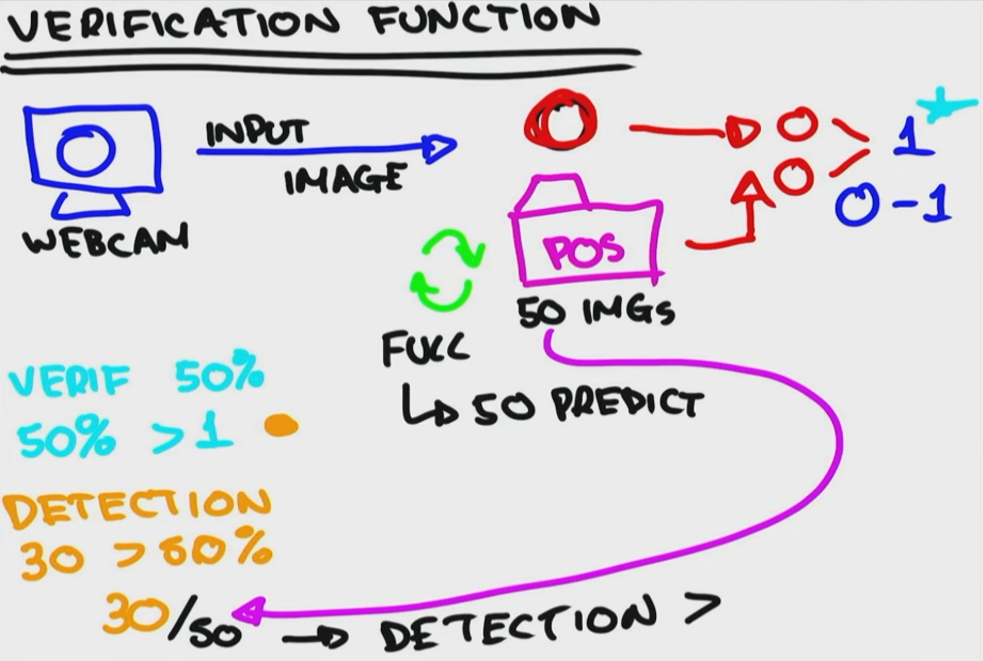

In [47]:
!mkdir application_data
!mkdir application_data\input_images
!mkdir application_data\verification_images

A subdirectory or file application_data already exists.
A subdirectory or file application_data\input_images already exists.
A subdirectory or file application_data\verification_images already exists.


#### Verification Function

In [48]:
import uuid

In [58]:
# Establish a connection to the webcam
cap = cv.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv.waitKey(1) & 0XFF == ord('v'):
        # Create the unique file path
        imgname = os.path.join('.\\application_data\\verification_images', '{}.png'.format(uuid.uuid1()))
        # Write out anchor image
        cv.imwrite(imgname, frame)

    # Show image back to the screen
    cv.imshow("Verification Collections", frame)

    # Breaking gracefully
    if cv.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv.destroyAllWindows()

In [52]:
def verify(model , detection_threshold , verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data' , 'verification_images')):
        input_img = preprocess(os.path.join('application_data' , 'input_images' , 'input_image.png'))
        validation_img = preprocess(os.path.join('application_data' , 'verification_images' , image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img , validation_img] , axis = 1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification Threshold: Proportion of positive prediction / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data' , 'verification_images')))
    verified = verification > verification_threshold
    
    return results , verified

#### OpenCV Real Time Verification

In [ ]:
cap = cv.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250, 200:200+250, :]
    
    if cv.waitKey(1) & 0XFF == ord('v'):
        imgname = os.path.join('application_data' , 'input_images' , 'input_image.png')
        cv.imwrite(imgname, frame)
        results , verified = verify(model , 0.5 , 0.5)
        print(verified)
        print(results)

    cv.imshow("Verification", frame)

    if cv.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()